In [1]:
import numpy as np
from scipy.integrate import ode

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

import keras
from keras.models import Sequential, Model
from keras.layers import LSTM,Dense, Bidirectional, Dropout, Input, RepeatVector, TimeDistributed
import keras.backend as kb


# Predicting particle trajectories with a Recurrent NN

In this notebook, we'll explore an application Recurrent NNs to predict the path of a charged particle in a magnetic field.  A traditional use of RNNs would be to predict a sequence of letters or words for text transcription or image labeling, but we can also try to use RNNs to find elements in a time-stepped sequence of a physical path.  This approach could easily be adapted to any number of applications:

* Predict the initial conditions of a particle given its path;
* Fill in missing data along a particle's path;
* In the case of multiple particle paths, predict which points belong to a given particle;
* Predict where a particle's trajectory would intersect with a detector element;

This notebook holds three useful examples:

1. How to use the scipy ODE module to integrate differential equations to find a particle's position as a function of time;
2. Use a "traditional" RNN to predict the next N steps of a one-dimensional path;
3. Use a more complicated encoder-decoder RNN architecture to predict the next N steps of a three-dimensional path.

***
***
# Part 1:  Start with generating path data for a particle in a magnetic field

Our goal for this step will be to generate N steps along the path of a charged particle moving in a uniform magnetic field.  We will make the last M steps be the targets to predict.  For example, if we product 100 points along the path, we can ask the RNN to predict the last 4 steps.  As an optional challenge, we can inject noise in the path of the particle, which might represent scattering as it passes through a medium.

We will need to specify the:
1. number of steps
2. $\Delta t$ between steps
3. particle charge
4. magnetic field strength
5. initial position
6. initial velocity
7. amount of noise along the particle's path

For this problem, the B field will be along the x axis and the particle's helical motion will be in the y-z plane.

In [2]:
# First we define the derivative using Newtonian motion
def newton(t, Y, q, m, B):
    """Computes the derivative of the state vector y according to the equation of motion:
    Y is the state vector (x, y, z, u, v, w) === (position, velocity).
    returns dY/dt.
    """
    x, y, z = Y[0], Y[1], Y[2]
    u, v, w = Y[3], Y[4], Y[5]
    
    alpha = q / m * B
    return np.array([u, v, w, 0, alpha * w, -alpha * v])


Training data shape:  (46, 3)
Target data shape:  (4, 3)


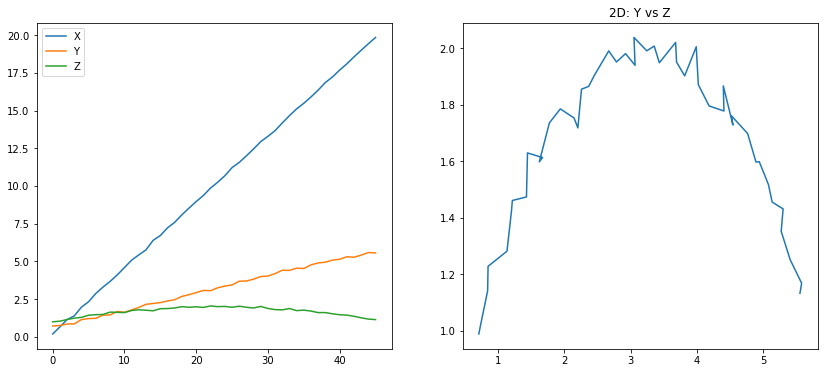

In [3]:
# Next we'll ste up our ODE integrator
r = ode(newton).set_integrator('dopri5')

# These variables will control our overall state for the problem.
# - Increase time steps to put more distance between points
# - Increase variance to add more noise to the path
# - Adjust the number of past steps to see how the RNN deals with longer or shorter sequences
variance = 0.05
time_step = 0.1
n_past = 46
n_future = 4

# Set initial position and velocity conditions
def getInitialConditions():
    x0 = np.array(np.random.rand(3))
    v0 = np.array([np.random.rand()*5, np.random.rand()*2, np.random.rand()*2])
    return np.concatenate((x0, v0))

# Generate a trajectory sequence in 3D space
def getTrajectory(ode, q=1.0, m=3.0, b=1.0, dt=0.05, noise=0, nPred=4, nPast=100):
    t0 = 0

    ode.set_initial_value(getInitialConditions(), t0).set_f_params(q,m,b)

    oPos = []
    oPos.append(ode.y[:3])
    while r.successful() and len(oPos) < nPred+nPast:
        r.integrate(ode.t+dt)
        var = np.random.randn(3)*noise
        oPos.append(ode.y[:3]+var) # keeping only position, not velocity

    ln = len(oPos)

    return np.array(oPos[:ln-nPred]), np.array(oPos[ln-nPred:ln])

# Let's grab one trajectory just to see what we got
posTrain, posTarget = getTrajectory(r, dt=time_step, noise=variance, nPred=n_future, nPast = n_past)

print("Training data shape: ", posTrain.shape)
print("Target data shape: ", posTarget.shape)


# Make some plots to visualize things
fig, ax = plt.subplots(1,2,figsize=(14,6))
ax[0].plot(posTrain[:, 0],label="X")
ax[0].plot(posTrain[:, 1],label="Y")
ax[0].plot(posTrain[:, 2],label="Z")
ax[0].legend()
ax[1].plot(posTrain[:, 1], posTrain[:, 2])
ax[1].set_title("2D: Y vs Z")
plt.show()

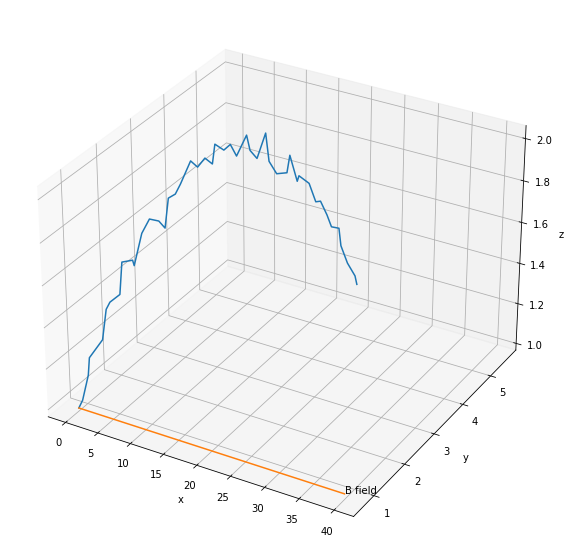

In [4]:
# Let's also make a 3D plot to see how the path looks 
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot3D(posTrain[:, 0], posTrain[:, 1], posTrain[:, 2])

B1 = np.array([posTrain[0,0], posTrain[0,1], posTrain[0,2]])
B2 = np.array([posTrain[-1,0]*2, 0,0])
B_axis = np.vstack((B1, B1 + B2))
ax.plot3D(B_axis[:, 0], 
         B_axis[:, 1],
         B_axis[:, 2])
plt.xlabel('x')
plt.ylabel('y')
ax.set_zlabel('z')
ax.text3D((B1 + B2)[0], (B1 + B2)[1], (B1 + B2)[2], "B field")
plt.show()

***
***
# Part 2: Create Training Data

A traditional RNN would be trained on a very long input sequence, for example the entire text of a book or series of books.  In our case, we have a relatively short path length (of order 100 steps or so) and are asking to predict a few steps.  So we will make 2000 random trajectories and train on them sequentially.

In [5]:
# Create arrays of training data
xTrain = []
yTrain = []
for idx in range(2000):
    X, y = getTrajectory(r, dt=time_step, noise=variance, nPred=n_future, nPast = n_past)
    xTrain.append(X)
    yTrain.append(y)
    
xTrain = np.array(xTrain)
yTrain = np.array(yTrain)
print("Training data shape: ", xTrain.shape)
print("Target data shape: ", yTrain.shape)

Training data shape:  (2000, 46, 3)
Target data shape:  (2000, 4, 3)


***
***
# Part 3: Create a "normal" 1D RNN

Let's make a RNN that only predicts one of the three spatial sequences.  For this problem, the x dimension is "too easy" as it's just a linearly increasing number.  So we should pick either the y or z dimensions.  We will use a Long Short Term Memory (LSTM) RNN unit for this problem.

In [6]:
# our inputs will be the first N points in the trajectory, for one variable
inputs = Input(shape=(n_past, 1))
print(inputs.shape)

# Next we'll build a LSTM layer with 10 outputs
# return_state=True means we return the last output to the next step
# In this configuration, the return values are [output], [hidden state], [cell state]
lstm_out, lstm_hidden, lstm_state = LSTM(50, return_state=True)(inputs)
print(lstm_out.shape)

# Finally we'll add a fully-connected layer with four outputs
outputs = Dense(n_future)(lstm_out)
print(outputs.shape)

# Build and compile our model
# Let's stick with Adam for GD optimization and MSE loss for regression
# Finally, let's also track accuracy in addition to the loss
model_1d = keras.Model(inputs=inputs, outputs=outputs)
model_1d.compile(optimizer="adam", loss="mse",metrics=['acc'])
model_1d.summary()

(None, 46, 1)
(None, 50)
(None, 4)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 46, 1)]           0         
_________________________________________________________________
lstm (LSTM)                  [(None, 50), (None, 50),  10400     
_________________________________________________________________
dense (Dense)                (None, 4)                 204       
Total params: 10,604
Trainable params: 10,604
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Let's train on the y-axis data
xTrain1D = xTrain[:,:,1]
yTrain1D = yTrain[:,:,1]
model_1d.fit(xTrain1D,yTrain1D, epochs=20,batch_size=50)

# Get predictions
predictions1D = model_1d.predict(xTrain1D)

# Divide by targets so we can plot our success...or lack of
predictions1D /= yTrain1D

Epoch 1/20
40/40 [==============================] - 1s 9ms/step - loss: 38.8354 - acc: 0.0450
Epoch 2/20
40/40 [==============================] - 0s 8ms/step - loss: 11.4328 - acc: 0.0586
Epoch 3/20
40/40 [==============================] - 0s 8ms/step - loss: 3.3157 - acc: 0.1988
Epoch 4/20
40/40 [==============================] - 0s 8ms/step - loss: 1.1996 - acc: 0.3231
Epoch 5/20
40/40 [==============================] - 0s 8ms/step - loss: 0.6755 - acc: 0.4525
Epoch 6/20
40/40 [==============================] - 0s 8ms/step - loss: 0.3684 - acc: 0.5561
Epoch 7/20
40/40 [==============================] - 0s 8ms/step - loss: 0.2493 - acc: 0.6410
Epoch 8/20
40/40 [==============================] - 0s 8ms/step - loss: 0.1263 - acc: 0.6677
Epoch 9/20
40/40 [==============================] - 0s 8ms/step - loss: 0.1016 - acc: 0.6731
Epoch 10/20
40/40 [==============================] - 0s 9ms/step - loss: 0.0670 - acc: 0.6983
Epoch 11/20
40/40 [==============================] - 0s 9ms/step - 


Min / Max, Step 0:  0.9054844 1.1390091
Mean / StdDev, Step 0:  0.9950166 0.015257885

Min / Max, Step 1:  0.8618533 1.0870843
Mean / StdDev, Step 1:  0.99081933 0.014946844

Min / Max, Step 2:  0.90781885 1.1606542
Mean / StdDev, Step 2:  0.99153185 0.016761014

Min / Max, Step 3:  0.8756709 1.2329867
Mean / StdDev, Step 3:  0.9924744 0.020889418


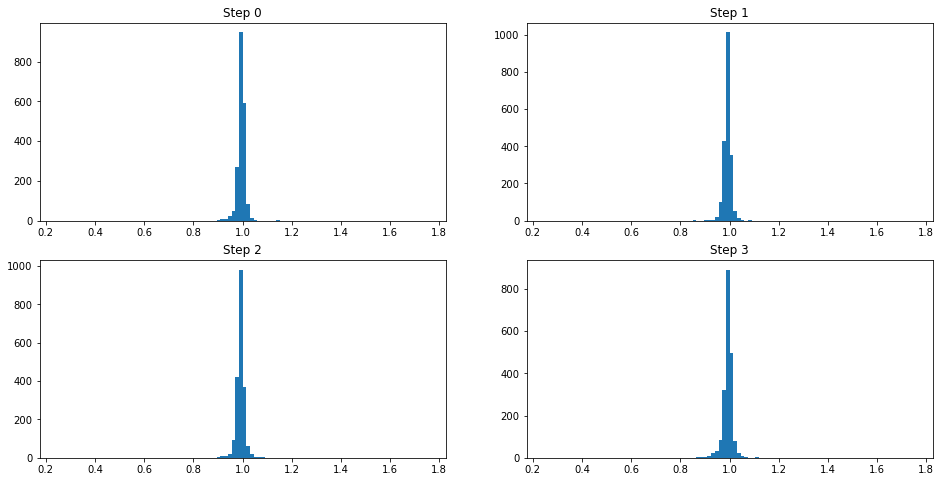

In [8]:
# Let's plot our results
# Note that the predictions are very good for the first step in the predicted sequence
# But for the subsequent steps, the predictions have larger variance
# This is not surprising and allows one to guess how far in the future we can "see"
for ix in range(predictions1D.shape[1]):
    print(f"\nMin / Max, Step {ix}: ",np.min(predictions1D[:,ix]), np.max(predictions1D[:,ix]))
    print(f"Mean / StdDev, Step {ix}: ",np.mean(predictions1D[:,ix]), np.std(predictions1D[:,ix]))

xmin = 0.25
xmax = 1.75

fig, ax = plt.subplots(2,2,figsize=(16,8))
for ix in range(2):
    for iy in range(2):
        ax[ix,iy].hist(predictions1D[:,2*ix+iy],bins=100,range=(xmin,xmax))
        ax[ix,iy].set_title(f"Step {2*ix+iy}")

***
***
# Part 4: Now let's predict all three spatial dimensions!

In the last example, we only predicted a sequence in one dimension.  But we have three spatial dimensions and it would be nice to get the full picture.  But this means that our output is more complex.  We do not have a simple one-dimensional sequence of numbers, but rather a three-dimensional sequence.  That means we need three outputs at each time step.  This is not a trivial thing to extract from a fully-connected final layer like in the 1D case.

Thus, we will deploy a "encoder-decoder" architecture where a normal LTSM structure is trained and the output is reshaped to the NxD structure required:

1. The inputs layer will be just like we used for the 1D case, just adding the two additional dimensions.
2. The inputs are then passed to a LSTM layer (the encoder) that includes the return state in its output.  
3. The *outputs* of the first LSTM layer becomes the input to a `RepeatVector` layer.  This layer makes N copies of the LSTM output.
4. A second LSTM (the decoder) is created to map the RepeatVector copies onto separate LSTM outputs for each prediction step.  The *hidden states* of the first LSTM are used to set the initial state of this LSTM, which sets the weights and current state.
5. The output of the second LSTM is passed to a `TimeDistributed` layer, which applies a specified layer to each slice of the input.  This means that for each predicted trajectory step we can apply a `Dense` layer that has 3 outputs, one for each spatial dimension.
6. The 3DxN-steps output of the `TimeDistributed` are then the output of our model.


In [9]:
# Create a Nx3 input layer
encoder_input = Input(shape=(n_past, 3))

# Set up a "normal" LSTM to operate on these inputs
encoder_output, encoder_hidden, encoder_state = LSTM(50, return_state=True)(encoder_input)

# The RepeatVector layer makes N=n_future copies of the encoder output
decoder_input = RepeatVector(n_future)(encoder_output)

# Create a second LSTM that takes all N copies of the encoder output.
# Set the initial state and weights to the values from the first LSTM/encoder
decoder_lstm = LSTM(50, return_sequences=True)(decoder_input,initial_state = [encoder_hidden, encoder_state])

# The decoder LSTM is then proc
decoder_output = TimeDistributed(Dense(units=3))(decoder_lstm)

# Build and compile our model
# Let's stick with Adam for GD optimization and MSE loss for regression
# Finally, let's also track accuracy in addition to the loss
model_3D = Model(encoder_input,decoder_output)
model_3D.compile(optimizer='adam', loss="mse",metrics=['acc'])
model_3D.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 46, 3)]      0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 50), (None,  10800       input_2[0][0]                    
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 4, 50)        0           lstm_1[0][0]                     
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 4, 50)        20200       repeat_vector[0][0]              
                                                                 lstm_1[0][1]               

In [10]:
model_3D.fit(xTrain,yTrain, epochs=30,batch_size=50)

predictions3D = model_3D.predict(xTrain)
predictions3D /= yTrain

Epoch 1/30
40/40 [==============================] - 2s 9ms/step - loss: 75.1015 - acc: 0.5377
Epoch 2/30
40/40 [==============================] - 0s 9ms/step - loss: 33.0429 - acc: 0.9124
Epoch 3/30
40/40 [==============================] - 0s 9ms/step - loss: 18.6013 - acc: 0.9564
Epoch 4/30
40/40 [==============================] - 0s 9ms/step - loss: 12.7911 - acc: 0.9771
Epoch 5/30
40/40 [==============================] - 0s 9ms/step - loss: 8.5521 - acc: 0.9860
Epoch 6/30
40/40 [==============================] - 0s 9ms/step - loss: 6.0154 - acc: 0.9842
Epoch 7/30
40/40 [==============================] - 0s 9ms/step - loss: 4.6904 - acc: 0.9908
Epoch 8/30
40/40 [==============================] - 0s 10ms/step - loss: 3.4794 - acc: 0.9910
Epoch 9/30
40/40 [==============================] - 0s 9ms/step - loss: 2.6503 - acc: 0.9886
Epoch 10/30
40/40 [==============================] - 0s 9ms/step - loss: 2.0443 - acc: 0.9907
Epoch 11/30
40/40 [==============================] - 0s 9ms/step

Min / Max, Layer 0/X:  0.79545665 2.978
Min / Max, Layer 0/Y:  0.8956866 3.9648645
Min / Max, Layer 0/Z:  -147.2039 40.779785
Min / Max, Layer 1/X:  0.61123437 1.8321196
Min / Max, Layer 1/Y:  0.86033386 2.971097
Min / Max, Layer 1/Z:  -550.20276 20.987782
Min / Max, Layer 2/X:  0.64289546 2.2213104
Min / Max, Layer 2/Y:  0.8531935 3.0404224
Min / Max, Layer 2/Z:  -51.30781 37.343346
Min / Max, Layer 3/X:  0.6305407 4.2839103
Min / Max, Layer 3/Y:  0.8307165 3.1665003
Min / Max, Layer 3/Z:  -55.227398 65.62553
Mean / StdDev, Layer 0/X:  1.0010358 0.06785866
Mean / StdDev, Layer 0/Y:  1.0142554 0.12191519
Mean / StdDev, Layer 0/Z:  0.90996706 3.7346168
Mean / StdDev, Layer 1/X:  1.0001794 0.03351992
Mean / StdDev, Layer 1/Y:  1.0064113 0.09256729
Mean / StdDev, Layer 1/Z:  0.69547087 12.431026
Mean / StdDev, Layer 2/X:  0.99909264 0.03958648
Mean / StdDev, Layer 2/Y:  1.0043617 0.09498787
Mean / StdDev, Layer 2/Z:  0.95753926 1.7121795
Mean / StdDev, Layer 3/X:  0.9997335 0.086411305
Me

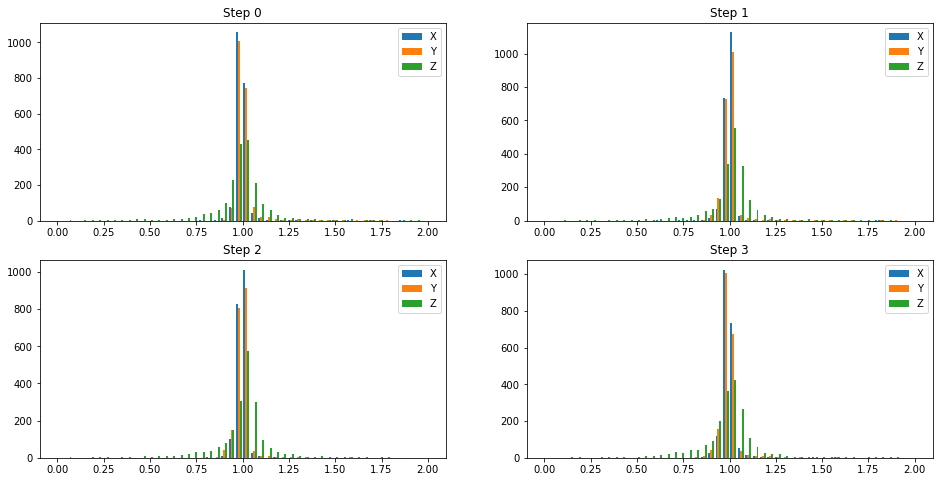

In [11]:
## More plots and statistics
xmin = 0
xmax = 2
labels = ("X","Y","Z")

for ix in range(predictions3D.shape[1]):
    for iy in range(predictions3D.shape[2]):
        print(f"Min / Max, Layer {ix}/{labels[iy]}: ",np.min(predictions3D[:,ix,iy]), np.max(predictions3D[:,ix,iy]))
for ix in range(predictions3D.shape[1]):
    for iy in range(predictions3D.shape[2]):
        print(f"Mean / StdDev, Layer {ix}/{labels[iy]}: ",np.mean(predictions3D[:,ix,iy]), np.std(predictions3D[:,ix,iy]))


fig, ax = plt.subplots(2,2,figsize=(16,8))
for ix in range(2):
    for iy in range(2):
        ax[ix,iy].hist(predictions3D[:,2*ix+iy],bins=50,range=(xmin,xmax),label=labels)
        ax[ix,iy].legend()
        ax[ix,iy].set_title(f"Step {2*ix+iy}")

plt.show()